In [2]:
from matplotlib import pyplot as plt
from matplotlib.dates import datestr2num
import pandas as pd
import numpy as np

In [3]:
prices = pd.read_csv('data/Dow_Jones_Data_Daily.csv')
start_date = pd.datetime(1985,1,30) (1985, 02, 01)
end_date   = pd.datetime(2019,9,30)
prices['Close'].plot()
plt.title('Daily Price of Dow Jones')
plt.xlabel('Date')
plt.ylabel('Price');

SyntaxError: invalid token (<ipython-input-3-5816773ea8f4>, line 2)

In [ ]:
#fig, ax = plt.subplots()
print (prices['Close'].values)
prices['Date'] = pd.to_datetime(prices['Date'])
#print ('index: ', prices['Close'].index)
#prices['Close'].index = prices['Date']
plt.plot(prices['Close'])
#ax.plot(prices['Close'], 'b-')
#ax.set_yaxis = prices['Close'].values
#ax.set_xaxis = prices['Date'].values
#ax.plot(prices['Close'], 'b-') #prices['close_price'], 'b-')
#ax.set_yaxis = prices['Close'].values
plt.title('Representation of Triple Barrier Method')
plt.xlabel('Date')
plt.ylabel('Price')

plt.plot([4000,4000], [5000, 15000], 'r-')  # Initiation of trade
plt.plot([4000,6000], [5000, 5000], 'r--') # Lower Barrier, here $160
plt.plot([4000,6000], [15000, 15000], 'r--') # Upper Barrier, here $180
plt.plot([6000,6000], [5000, 15000], 'r-') # Vertical Barrier, here 140 days after initiation
plt.show()

In [4]:
def get_daily_vol (securities, start_date, end_date, lookback=20):
    '''
    Returns the daily volatility of all stocks in the close_prices Dataframe, reindexed to close
        -Used to calculate daily stop loss/profit taking thresholds
        -Calculated as the exponentially weighted moving standard deviation (EWM) of returns over lookback days
        -Output will begin 3 days after start_date

    Parameters
    ----------
    securities : list
        -List of symbol objects for pricing data to be derived from
        -Example: '[Equity(5061 [MSFT]), Equity(24 [AAPL]), Equity(49311 [AQMS])]'
                
    start_date : str
        -Starting date for pricing data to be collected from
        -First value for volatility will be lookback trading days after start_date
        
    end_date : str
        -Ending date for pricing data to be collected from
        
    lookback : float, optional, default 20 bars
        -The number of trading days used by the EWM function to calculate the given day's volatility.
        
    Output
    ----------
    daily_vol : pd.DataFrame
        -Daily volatility of a universe of stocks (columns) over some series of trading days (indices)
        -First value will be NaN
        -Example:
                
                                     MSFT        AAPL    
        2016-11-02 00:00:00+00:00    0.011824    0.012861
        2016-11-03 00:00:00+00:00    0.011807    0.012919
        2016-11-04 00:00:00+00:00    0.011844    0.012953
        2016-11-07 00:00:00+00:00    0.012097    0.013016
    '''
    # Gets pricing data for all securities over timespan
    close_prices = prices['Close'] #get_pricing(securities, start_date, end_date, frequency='daily', fields='close_price')
    #dates = prices['Date']
    #close_prices.index = pd.DatetimeIndex(prices.Timestamp)
    prices['Date'] = pd.to_datetime(prices['Date'])
    prices2 = prices.set_index('Date')
    close_prices.index = prices2.index
    #print ("prices2 ", prices2.index)
    #df['Date'] = pd.to_datetime(df.Timestamp)
    
    # pd.offsets.Bday() * lookback
    # Calculate returns with .pctchange
    #print("close_prices.index", dates)
    #print('pd.Timedelta(days=1)', pd.Timedelta(days=1))
    #print("close_prices.index", prices2.index - np.timedelta64(1,'D'))
    # Sets daily_vol as a series of index dates with values of following dayes
    daily_vol = close_prices.index.searchsorted(prices2.index - np.timedelta64(1,'D')) #)pd.Timedelta(days=1))
    daily_vol = daily_vol[daily_vol>0]
    #print ('daily_vol2: ', daily_vol)
    daily_vol = pd.Series(data=close_prices.index[daily_vol - 1], 
                          index=close_prices.index[close_prices.shape[0]-daily_vol.shape[0]:])
    # Uses that structure to simply calculate daily returns, if no duplicate indices
    try:
        daily_vol = (close_prices.loc[daily_vol.index] / 
            close_prices.loc[pd.to_datetime(daily_vol.values, utc=True)].values-1) # daily returns
    except Exception as e:
        print('error: {}\nplease confirm no duplicate indices'.format(type(e).__name__, e))
    #print ('daily_vol3: ', daily_vol)    
    # Calculates the exponentially weighted moving standard deviation of returns
    #print ('daily_vol4: ', daily_vol)
    daily_vol = daily_vol.ewm(span=lookback).std()
    
    # Skips the first value (always NaN) and returns
    #print ('daily vol: ', daily_vol.iloc[1:])
    return daily_vol.iloc[1:]

In [5]:
plt.plot(get_daily_vol(prices, start_date, end_date));
plt.xlabel('Daily Volatility')
plt.ylabel('Date')
plt.title('Daily Volatility of Stock')

NameError: name 'prices' is not defined

In [6]:
def TripleBarrierMethod(securities, start_date, end_date, upper_lower_multipliers, t_final=10):
    '''
    Simulates path-dependent stop loss / profit taking behavior for given securities
    
    Note: Based on CLOSE PRICES, for low-frequency data this really fails to maintain the intuition behind stop/limit orders
    Constructs up to three barriers (any can be disabled):
        -Upper horizontal barrier: the price of a profit taking order
        -Lower horizontal barrier: the price of a stop loss order
        -Rightward vertical barrier: the time where the instrument is sold regardless of performance
    Treats each security on each bar independently
    Output is in range [-1, 1] for each date/security.
    If that security was bought on that date, if the stop loss is hit by t_final days, -1.
    Profit taking order, +1. If the vertical barrier hit, in range (-1, 1) depending on how close it finished to each horizontal barrier
    If no barrier is hit, NaN output.
    Output will be delayed by enough days to calculate the volatilities (default 100, can be change)
    
    Parameters
    ----------
    securities : list
        -List of symbol objects for pricing data to be derived from
        -Example: '[Equity(5061 [MSFT]), Equity(24 [AAPL])'
                
    start_date : str
        -Starting date for pricing data to be collected from
        -First value for volatility will be lookback trading days after start_date
        
    end_date : str
        -Ending date for pricing data to be collected from
    
    upper_lower_multipliers : list, non-negative float
        upper_lower_multipliers[0]: Factor multiplied by daily_vol to set width of upper barrier
        upper_lower_multipliers[1]: Factor multiplied by daily_vol to set width of lower barrier
        0 to disable either barrier
        
    t_final : integer
        The static number of days from each purchase to set the vertical barrier. 0 to disable, 10 by default.
        
    Output
    ----------
        out : DataFrame (index = dates, values = [-1, 1] for each security)
            For the given start-date (index), did each security (column header) tested either
                -Hit the top barrier first? Set value to 1
                -Hit the bottom barrier first? Set value to -1
                -Hit the vertical barrier first? Set value to weighted return over timespan
                    (As end price approaches a barrier, approaches 1 or -1)
                -Hits no barrier before the data runs out? NaN
            -Example:
            
                                         MSFT        AAPL
        2016-11-02 00:00:00+00:00          -1           1
        2016-11-03 00:00:00+00:00           1           1
        2016-11-04 00:00:00+00:00    0.401802           1
        2016-11-07 00:00:00+00:00           1         NaN
                
    '''
    close_prices = prices['Close'] #get_pricing(securities, start_date, end_date, frequency='daily', fields='close_price')
    #dates = prices['Date']
    #close_prices.index = pd.DatetimeIndex(prices.Timestamp)
    prices['Date'] = pd.to_datetime(prices['Date'])
    prices2 = prices.set_index('Date')
    close_prices.index = prices2.index
    # Daily EWMSTD volatility for date range (not including first 3 trading days)
    # Default is 20 day EWM
    daily_vol = get_daily_vol(prices, start_date, end_date)
    #print ('daily_vol :', daily_vol)
    #daily_vol = get_daily_vol(securities, start_date, end_date)
    #daily_vol.index = close_prices.index
    # Daily prices for securities on time-span (uses vol's start date, data before vol available useless)
    #prices = get_pricing(securities, daily_vol.index[0], pd.to_datetime(end_date, utc=True), frequency='daily', fields = ['high', 'low', 'close_price'])
    #close_prices = prices.loc['close_price']
    #print (prices)
    highs = prices['High'] #prices.loc['High']
    highs.index = close_prices.index
    lows = prices['Low'] #prices.loc['Low']
    lows.index = close_prices.index
    # Output uses vol's index for same reason as above
    out = pd.DataFrame(index = daily_vol.index)
    #print ('out: ', out)
    # Iterates over daily_vol for all dates (even those less than t_final days before end_date)
    # That becomes important later
    for day, vol in daily_vol.iteritems(): #rows():
        #print ('NEW DAY: ')
        #print ('day: ', day, ' vol :', vol)
        # Total # of days passed from the start of analysis (not start date)
        days_passed = len(daily_vol.loc[daily_vol.index[0] : day])
        #print ('days_passed: ', days_passed)
        # Sets vertical barrier to t_final days after current day, only if enough days remain in dataset
        # Otherwise, set it to NaN
        if (days_passed + t_final < len(daily_vol.index) and t_final != 0):
            vert_barrier = daily_vol.index[days_passed + t_final]
        else:
            vert_barrier = np.nan
        #print ('vert_barrier: ', vert_barrier)    
        # If the top barrier is set to exist, set it to day's close price + that price, times the predicted vol, times the multiplier
        # Otherwise, set it to NaN. Applies to all securities on this day (uses each security's vol)
        if upper_lower_multipliers[0] > 0:
            top_barrier = close_prices.loc[day] + close_prices.loc[day] * upper_lower_multipliers[0] * vol
        else:
            top_barrier = pd.Series(index=close_prices.index) # NaNs
        #print ('top_barrier: ', top_barrier)    
        # Same for bottom barrier
        if upper_lower_multipliers[1] > 0:
            bot_barrier = close_prices.loc[day] - close_prices.loc[day] * upper_lower_multipliers[1] * vol
        else:
            bot_barrier = pd.Series(index=close_prices.index) # NaNs
        #print ('bottom barrier: ', bot_barrier)
        # Iterate over all securities
        ########for security in close_prices.columns:######
        security = 'DOW'
        # Default break date for security is the vertical barrier (even if NaN)
        breakthrough_date = vert_barrier
        #print ('breakthrough_date ',breakthrough_date)
        #print ('highs: ', highs)
        #print ('top barrier: ', top_barrier)
        # For t_final days after current date (or remaining days in time_frame, whichever ends first)
        #print (daily_vol.index[days_passed : min(days_passed + t_final, len(daily_vol.index))])
        for future_date in daily_vol.index[days_passed : min(days_passed + t_final, len(daily_vol.index))]:
            #print ('breakthrough_date: ', breakthrough_date)
            #print ('(highs.loc[{}][{}]: {} '.format(future_date, 'DOW ',highs.loc[future_date]))
            # If other barriers were broken on current date, set breakthrough_date to it
            if ((highs.loc[future_date] >= top_barrier or 
                 close_prices.loc[future_date] >= top_barrier and
                 top_barrier != 0)):
                out.at[day, security] = 1
                breakthrough_date = future_date
                break
            elif (lows.loc[future_date] <= bot_barrier or
                  close_prices.loc[future_date] <= bot_barrier and 
                  bot_barrier != 0):
                out.at[day, security] = -1
                breakthrough_date = future_date
                break
        #print ('out: ', out)
        if (breakthrough_date == vert_barrier):
            # Initial and final prices for security on timeframe (purchase, breakthrough)
            price_initial = close_prices.loc[day]
            price_final   = close_prices.loc[breakthrough_date]
            #print ('out.at[day]: ',out.at[day, security])
            #print ('price_initial: ', price_initial)
            #print ('price_final: ', price_final)
            #print ('top_barrier: ', top_barrier, 'bot_barrier: ', bot_barrier)
            if price_final > top_barrier:
                out.at[day, security] = 1
            elif price_final < bot_barrier:
                out.at[day, security] = -1
            else:
                out.at[day, security] = max([(price_final - price_initial) / (top_barrier - price_initial),
                                         (price_final - price_initial) / (price_initial - bot_barrier)], key=abs)
            #print ('out.at[{}]: {}'.format(day,out.at[day, security]))
    # Purge last value; a trade can never be initiated here (trades made at close)
    return out[:-1]

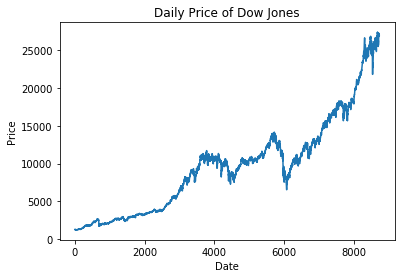

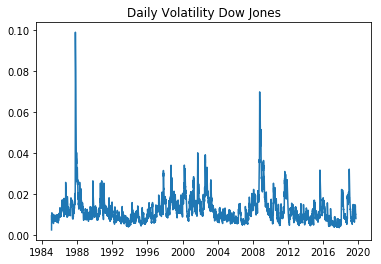

daily vol:  Date
1985-02-01    0.002378
1985-02-04    0.009582
1985-02-05    0.008309
1985-02-06    0.008169
1985-02-07    0.007393
1985-02-08    0.007225
1985-02-11    0.008212
1985-02-12    0.008392
1985-02-13    0.010601
1985-02-14    0.010212
1985-02-15    0.010744
1985-02-19    0.009993
1985-02-20    0.009323
1985-02-21    0.008724
1985-02-22    0.008380
1985-02-25    0.007896
1985-02-26    0.007949
1985-02-27    0.007521
1985-02-28    0.007127
1985-03-01    0.008072
1985-03-04    0.008201
1985-03-05    0.008035
1985-03-06    0.007940
1985-03-07    0.008897
1985-03-08    0.008645
1985-03-11    0.008210
1985-03-12    0.007890
1985-03-13    0.007547
1985-03-14    0.007451
1985-03-15    0.007508
                ...   
2019-08-19    0.014631
2019-08-20    0.014033
2019-08-21    0.013433
2019-08-22    0.013377
2019-08-23    0.014232
2019-08-26    0.014116
2019-08-27    0.013605
2019-08-28    0.013070
2019-08-29    0.014214
2019-08-30    0.014005
2019-09-03    0.013967
2019-09-04    0.0

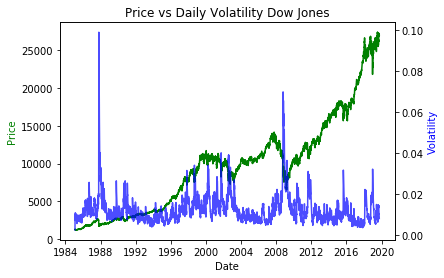

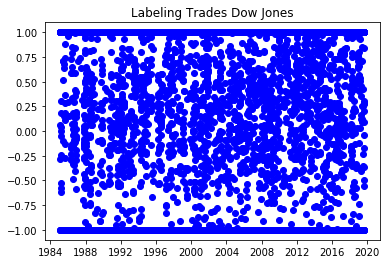

Hello!
close:  Date
1985-01-29     1292.619995
1985-01-30     1287.880005
1985-01-31     1286.770020
1985-02-01     1277.719971
1985-02-04     1290.079956
1985-02-05     1285.229980
1985-02-06     1280.589966
1985-02-07     1290.079956
1985-02-08     1289.969971
1985-02-11     1276.060059
1985-02-12     1276.609985
1985-02-13     1297.920044
1985-02-14     1287.880005
1985-02-15     1282.020020
1985-02-19     1280.589966
1985-02-20     1283.130005
1985-02-21     1279.040039
1985-02-22     1275.839966
1985-02-25     1277.500000
1985-02-26     1286.109985
1985-02-27     1281.030029
1985-02-28     1284.010010
1985-03-01     1299.359985
1985-03-04     1289.530029
1985-03-05     1291.849976
1985-03-06     1280.369995
1985-03-07     1271.530029
1985-03-08     1269.660034
1985-03-11     1268.550049
1985-03-12     1271.750000
                  ...     
2019-08-19    26135.789063
2019-08-20    25962.439453
2019-08-21    26202.730469
2019-08-22    26252.240234
2019-08-23    25628.900391
2019-08-

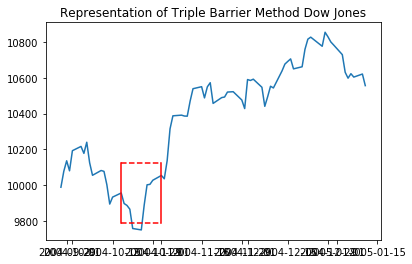

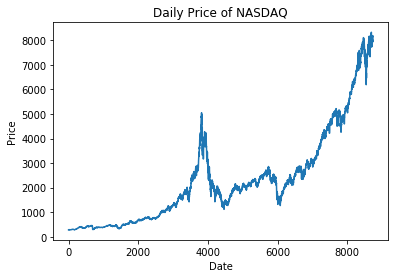

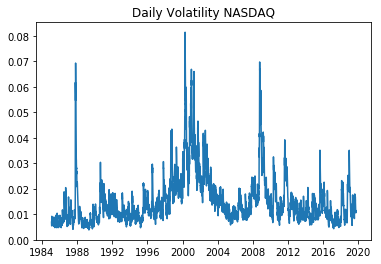

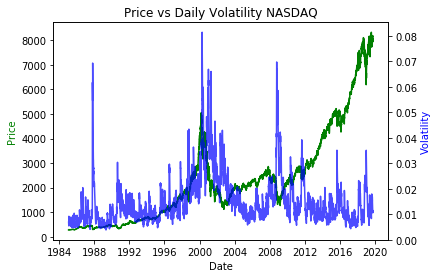

out:                   DOW
Date                
1985-02-01  1.000000
1985-02-04  1.000000
1985-02-05  1.000000
1985-02-06  1.000000
1985-02-07 -0.902198
1985-02-08 -1.000000
1985-02-11 -0.737807
1985-02-12 -0.454556
1985-02-13 -0.223598
1985-02-14 -1.000000
1985-02-15 -0.133023
1985-02-19 -0.313957
1985-02-20 -0.954948
1985-02-21 -1.000000
1985-02-22 -1.000000
1985-02-25 -0.626068
1985-02-26 -1.000000
1985-02-27 -1.000000
1985-02-28 -1.000000
1985-03-01 -1.000000
1985-03-04 -1.000000
1985-03-05 -1.000000
1985-03-06 -1.000000
1985-03-07 -1.000000
1985-03-08 -1.000000
1985-03-11 -1.000000
1985-03-12 -1.000000
1985-03-13  0.000000
1985-03-14  0.417713
1985-03-15  0.586897
...              ...
2019-08-16 -0.077913
2019-08-19 -0.092070
2019-08-20  0.625817
2019-08-21 -1.000000
2019-08-22 -1.000000
2019-08-23  1.000000
2019-08-26  1.000000
2019-08-27  1.000000
2019-08-28  1.000000
2019-08-29  1.000000
2019-08-30  1.000000
2019-09-03  1.000000
2019-09-04  1.000000
2019-09-05  0.003062
2019-09

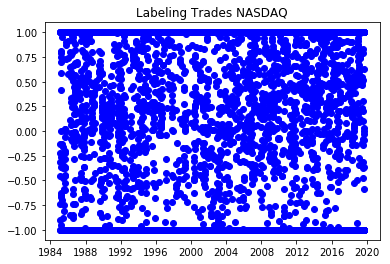

Hello!
close:  Date
1985-01-29     276.200012
1985-01-30     278.600006
1985-01-31     278.700012
1985-02-01     278.399994
1985-02-04     280.799988
1985-02-05     282.600006
1985-02-06     284.500000
1985-02-07     287.100006
1985-02-08     288.399994
1985-02-11     287.399994
1985-02-12     286.600006
1985-02-13     288.299988
1985-02-14     288.399994
1985-02-15     287.700012
1985-02-19     286.899994
1985-02-20     287.299988
1985-02-21     287.000000
1985-02-22     286.200012
1985-02-25     284.000000
1985-02-26     285.000000
1985-02-27     284.100006
1985-02-28     284.200012
1985-03-01     287.200012
1985-03-04     287.100006
1985-03-05     287.100006
1985-03-06     285.500000
1985-03-07     283.200012
1985-03-08     282.399994
1985-03-11     281.200012
1985-03-12     281.399994
                 ...     
2019-08-19    8002.810059
2019-08-20    7948.560059
2019-08-21    8020.209961
2019-08-22    7991.390137
2019-08-23    7751.770020
2019-08-26    7853.740234
2019-08-27    7826

ValueError: view limit minimum -36597.85 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x11e568840> (for post_execute):


ValueError: view limit minimum -36597.85 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

ValueError: view limit minimum -36597.85 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

In [8]:
start_date = pd.datetime(1985,1,30)
end_date   = pd.datetime(2019,9,30)
prices = pd.read_csv('data/Dow_Jones_Data_Daily.csv')
prices['Close'].plot()
plt.title('Daily Price of Dow Jones')
plt.xlabel('Date')
plt.ylabel('Price');
plt.show()
daily_vol = get_daily_vol(prices, start_date, end_date)
plt.plot(daily_vol);
plt.title('Daily Volatility Dow Jones')
plt.show()
print ('daily vol: ', daily_vol)
print ('dates: ', prices['Date'])
out = TripleBarrierMethod(prices, start_date, end_date, [2,2], t_final=10)
print ('out dow: ', out)
#
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(prices['Date'], prices['Close'], 'g-')
ax2.plot(prices['Date'][3:], daily_vol, 'b-', alpha=0.7)

ax1.set_xlabel('Date')
ax1.set_ylabel('Price', color='g')
ax2.set_ylabel('Volatility', color='b')
ax1.set_title('Price vs Daily Volatility Dow Jones')
plt.show()
#
#print ('out: ', out)
plt.title('Labeling Trades Dow Jones')
plt.plot(out, 'bo');
plt.show()
np.savetxt("Dow_daily_labels.csv", out, delimiter=" ")
#
close = prices['Close']
close.index = prices['Date']
print ('Hello!')
print ('close: ', close)
start = close.index[4975].to_pydatetime()
end   = close.index[4975 + 10].to_pydatetime()
vol   = daily_vol.loc[start]
upper_barrier = close.loc[start] + close.loc[start] * 2 * vol
lower_barrier = close.loc[start] - close.loc[start] * 2 * vol
plt.plot(prices['Close'][4960:5035]);

plt.title('Representation of Triple Barrier Method Dow Jones')
plt.plot([start, end], [upper_barrier, upper_barrier], 'r--');
plt.plot([start, end], [lower_barrier, lower_barrier], 'r--');
plt.plot([start, start], [lower_barrier, upper_barrier], 'r-');
plt.plot([end, end], [lower_barrier, upper_barrier], 'r-');
plt.show()

####

prices = pd.read_csv('data/NASDAQ_Data_Daily.csv')
prices['Close'].plot()
plt.title('Daily Price of NASDAQ')
plt.xlabel('Date')
plt.ylabel('Price');
plt.show()
daily_vol = get_daily_vol(prices, start_date, end_date)
plt.title('Daily Volatility NASDAQ')
plt.plot(daily_vol);

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(prices['Date'], prices['Close'], 'g-')
ax2.plot(prices['Date'][3:], daily_vol, 'b-', alpha=0.7)

ax1.set_xlabel('Date')
ax1.set_ylabel('Price', color='g')
ax2.set_ylabel('Volatility', color='b')
ax1.set_title('Price vs Daily Volatility NASDAQ')
plt.show()

out = TripleBarrierMethod(prices, start_date, end_date, [2,2], t_final=10)
print ('out: ', out)
plt.title('Labeling Trades NASDAQ')
plt.plot(out, 'bo');
plt.show()
np.savetxt("NASDAQ_daily_labels.csv", out, delimiter=" ")
close = prices['Close']
close.index = prices['Date']
print ('Hello!')
print ('close: ', close)
start = close.index[4975].to_pydatetime()
end   = close.index[4975 + 10].to_pydatetime()
vol   = daily_vol.loc[start]
upper_barrier = close.loc[start] + close.loc[start] * 2 * vol
lower_barrier = close.loc[start] - close.loc[start] * 2 * vol
plt.plot(prices['Close'][4960:5035]);


####
prices = pd.read_csv('data/S&P500_Data_Daily.csv')
prices['Close'].plot()
plt.title('Daily Price of S&P')
plt.xlabel('Date')
plt.ylabel('Price');
plt.show()
daily_vol = get_daily_vol(prices, start_date, end_date)
plt.title('Daily Volatility S&P500')
plt.plot(daily_vol);
plt.show()

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(prices['Date'], prices['Close'], 'g-')
ax2.plot(prices['Date'][3:], daily_vol, 'b-', alpha=0.7)

ax1.set_xlabel('Date')
ax1.set_ylabel('Price', color='g')
ax2.set_ylabel('Volatility', color='b')
ax1.set_title('Price vs Daily Volatility S&P500')
plt.show()

out = TripleBarrierMethod(prices, start_date, end_date, [2,2], t_final=10)
print ('out: ', out)
plt.title('Labeling Trades S&P500')
plt.plot(out[100:130], 'bo');
plt.show()
np.savetxt("SP_daily_labels.csv", out, delimiter=" ")
close = prices['Close']
close.index = prices['Date']
print ('Hello!')
print ('close: ', close)
start = close.index[4975].to_pydatetime()
end   = close.index[4975 + 10].to_pydatetime()
vol   = daily_vol.loc[start]
upper_barrier = close.loc[start] + close.loc[start] * 2 * vol
lower_barrier = close.loc[start] - close.loc[start] * 2 * vol
plt.plot(prices['Close'][4960:5035]);
plt.title('Representation of Triple Barrier Method Dow Jones')
plt.plot([start, end], [upper_barrier, upper_barrier], 'r--');
plt.plot([start, end], [lower_barrier, lower_barrier], 'r--');
plt.plot([start, start], [lower_barrier, upper_barrier], 'r-');
plt.plot([end, end], [lower_barrier, upper_barrier], 'r-');
plt.show()
#out = TripleBarrierMethod(['SPY'], start_date, end_date, [2, 2], t_final=10)
#plt.plot(out, 'bo');

#prices.insert(5, "Labels", out, True)
#print ('P2: ', prices)'''